In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
from collections import deque
from scipy.stats import *
import copy
import seaborn as sns
from Test import *
import math
import itertools
import pandas as pd
import plotly.express as px
from ipywidgets import interact, IntSlider


# %matplotlib notebook
%matplotlib widget


In [29]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [30]:
# Graph
required_probability=0.999
num_nodes, G,A,pos,r_c=build_random_graph(50,required_probability,fix_num_nodes=True) #  ,r_fix=999 or 0.3
print("num_nodes:",num_nodes)
pos = nx.spring_layout(G)  # Fixed positions for consistent visualization
percentageCorrupt = 0/num_nodes   #Percentage of corrupt clients




var = 30                  # Standard deviation for Gaussian noise
mean = 1                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 0              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)

lying_nodes = np.where(CorruptClients == 1)[0]
true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]

test1 = 0
# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 30
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))
    test1 += G.degree(i)

print(test1/num_nodes)

Control = Data.copy()

neighbors_dict = {}
for ln in lying_nodes:
    neighbors_dict[ln] = list(G.neighbors(ln))

print("Neighbors of lying nodes:", neighbors_dict)



num_nodes: 50
IteNumber of Corrupt nodesration 0, Corrupt nodes: []
10.2
Neighbors of lying nodes: {}


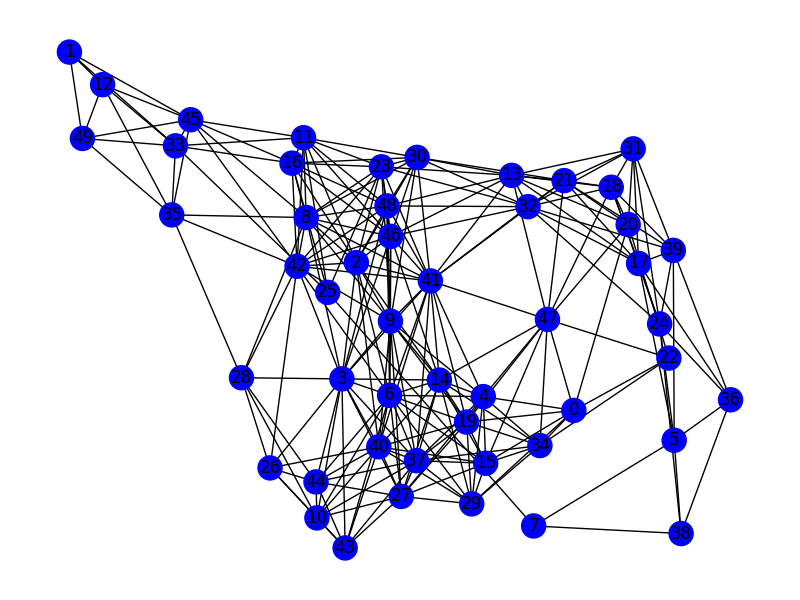

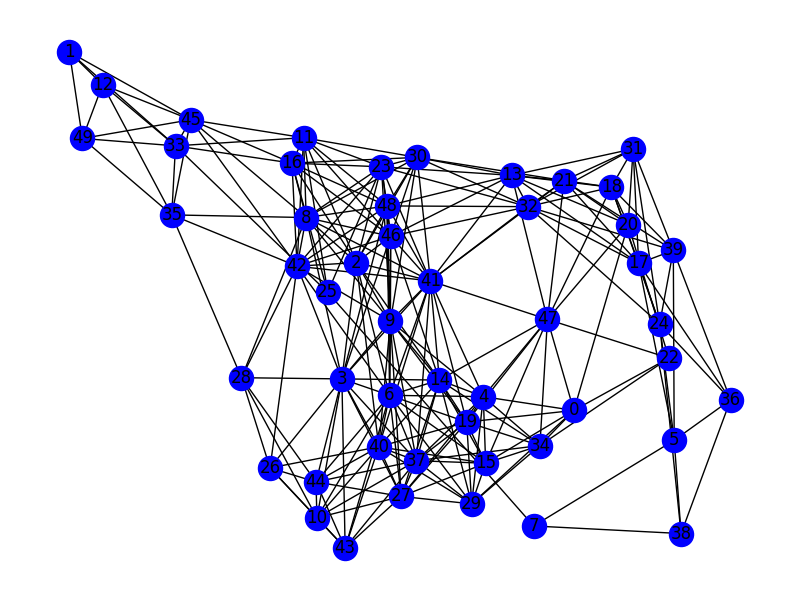

Are the honest‐only nodes still forming a connected subgraph? True


In [31]:
plt.figure(figsize=(8,6))
color_map = []
for node in range(num_nodes):
    if node in lying_nodes:
        color_map.append('red')   # corrupt
    else:
        color_map.append('blue')  # honest

nx.draw(G, pos, with_labels=True, node_color=color_map)
plt.title("Graph with Lying (Red) and Honest (Blue) Nodes")
plt.show()

remaining_nodes = [n for n in G.nodes() if n not in lying_nodes]
G_sub = G.subgraph(remaining_nodes)

pos_sub = {n: pos[n] for n in remaining_nodes}

plt.figure(figsize=(8,6))
nx.draw(G_sub, pos_sub, with_labels=True, node_color="blue")
plt.title("Subgraph After Removing Corrupt Nodes\n(Honest Nodes Only)")

plt.show()

still_connected = nx.is_connected(G_sub)
print("Are the honest‐only nodes still forming a connected subgraph?",
      still_connected)




In [32]:
def check_U_values(theta_now, i, G, num_nodes, epsilon=1e-14):
    """Compute MAD-normalized deviations U_{i,j}(t) for each neighbor j of node i."""
    U = np.zeros(num_nodes)
    neighbor_indices = list(G.neighbors(i))
    
    for j in neighbor_indices:
        # Get neighbors l ≠ j for robustness calculation
        other_neighbors = [l for l in neighbor_indices if l != j]
        
        if not other_neighbors:  # Edge case: no other neighbors
            U[j] = 0.0
            continue

        # 1. Collect current data from other neighbors
        theta_other = [theta_now[l][i] for l in other_neighbors]
        
        # 2. Compute median and MAD (component-wise for vectors)
        median_val = np.median(theta_other, axis=0)
        abs_devs = np.abs(theta_other - median_val)
        mad_val = np.median(abs_devs, axis=0)
        
        # 3. Compute normalized deviation for target neighbor j
        theta_j = theta_now[j][i]
        if mad_val == 0:
            normalized_dev = (theta_j - median_val) / 0.1
        else:
            normalized_dev = (theta_j - median_val) / (mad_val + epsilon)
        # print(mad_val)
        # 4. Infinity norm for vector values
        U[j] = np.max(np.abs(normalized_dev)) if isinstance(theta_j, np.ndarray) else np.abs(normalized_dev)
    
    # Dummy returns for compatibility with existing code structure
    return U, np.zeros(num_nodes), 0.0

In [33]:
def PDMM(
    Data, G, avg_temp, tolerance, c, max_iters, Control,
    averaging, K_decision, rejection_threshold, perm_threshold, 
    corruption_start, lying_nodes, window_size, CorruptValue, Print_Val,
    remove_node_iter=-1, re_add_node_iter=-1, target_node=2,
    remove_edge_iter=-1, re_add_edge_iter=-1, target_edge=(0,1)
):
    """
    Modified PDMM to investigate y behavior during node/edge removal and recovery.
    """
    np.random.seed(2001)
    num_nodes = G.number_of_nodes()
    x = np.zeros((num_nodes, 1))
    converged = False
    Error = []
    # Incidence matrix and Laplacian setup
    A_ij = nx.to_numpy_array(G)
    A = A_ij.copy()
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    # Variables initialization
    z = np.zeros((num_nodes, num_nodes))
    # z = np.random.normal(loc=0, scale=10**6, size=(num_nodes, num_nodes))
    # z = z * (A != 0) 
    y = np.zeros((num_nodes, num_nodes))
    y_transmit = np.zeros((num_nodes, num_nodes))
    dual = np.zeros((num_nodes, num_nodes))
    temp_y = np.zeros((num_nodes, num_nodes))
    manual_mask = np.zeros((num_nodes, num_nodes), dtype=int)  # For manual interventions
    temp_y = np.zeros((num_nodes, num_nodes))

    # History tracking
    y_history = []
    x_history = []
    dual_history = []
    mask_history = []
    count = 0
    while not converged and count < max_iters:
        # Apply manual node/edge removal
        if count == remove_node_iter:
            for j in G.neighbors(target_node):
                manual_mask[target_node][j] = -1
                manual_mask[j][target_node] = -1
        if count == re_add_node_iter:
            for j in G.neighbors(target_node):
                manual_mask[target_node][j] = 0
                manual_mask[j][target_node] = 0
        if count == remove_edge_iter:
            i, j = target_edge
            manual_mask[i][j] = -1
            manual_mask[j][i] = -1
        if count == re_add_edge_iter:
            i, j = target_edge
            manual_mask[i][j] = 0
            manual_mask[j][i] = 0
        # 1. Update x
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            numerator = Data[i].copy()
            valid_neighbors = 0
            for j in G.neighbors(i):
                if manual_mask[i][j] != -1:  # Consider manual mask
                    numerator -= A[i][j] * z[i][j]  # z[j] is a scalar
                    valid_neighbors += 1
            x_new[i] = numerator / (1 + c * valid_neighbors)
        x = x_new
        x_history.append(x.copy())

        # 2. Update dual variables
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # if mask[i][j]!= -1:
                dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])
        dual_history.append(dual.copy())
        # 3. Update y
        for i in range(num_nodes):
            for j in G.neighbors(i):
                temp_y[i][j] = y[i][j]
                y[i][j] = 2 * dual[i][j] - z[i][j]

    
        y_history.append(y.copy())
        # 4. Transmit y with masks
        y_transmit = np.zeros_like(y)
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if manual_mask[i][j] == -1:
                    y_transmit[i] = 0
                else:
                    y_transmit[i] = y[j]  # y[j] is a scalar
        # 5. Update z with averaging
        for i in range(num_nodes):
                for j in G.neighbors(i):
                    # Check if i is allowed to receive from j (j sends to i)
                    if manual_mask[i][j] == -1:
                        z[i][j] = (1 - averaging) * z[i][j]  # Block reception
                    else:
                        # Update z[i][j] with y sent from j to i
                        z[i][j] = (1 - averaging) * z[i][j] + averaging * y_transmit[j][i]
        mask_history.append(manual_mask.copy())

        # Convergence check
        diff = np.abs(x - avg_temp)
        norm_diff = np.linalg.norm(diff)
        Error.append(norm_diff)
        if norm_diff < tolerance:
            converged = True
        count += 1
    return {
        'y_history': y_history,
        'x_history': x_history,
        'dual_history': dual_history,
        'mask_history': mask_history,
        'error': Error
    }

In [34]:
def analyze_results(results, target_node=2, target_edge=(0,1)):
    """Plot y values for target node/edge and neighbors."""
    y_hist = results['y_history']
    masks = results['mask_history']
    
    # Plot y values for target node's edges
    plt.figure(figsize=(12, 6))
    for iter in range(len(y_hist)):
        y = y_hist[iter]
        # Track edges to/from target node
        for j in range(y.shape[1]):
            if j != target_node:
                plt.scatter(iter, y[target_node][j], c='blue', alpha=0.5)
                plt.scatter(iter, y[j][target_node], c='red', alpha=0.5)
    plt.title(f"Y values for Node {target_node}'s Edges")
    plt.xlabel("Iteration")
    plt.ylabel("Y Value")
    
    # Annotate removal/recovery points
    if 'remove_node_iter' in results.get('params', {}):
        plt.axvline(results['params']['remove_node_iter'], c='k', linestyle='--')
        plt.axvline(results['params']['re_add_node_iter'], c='g', linestyle='--')
    plt.show()

    # Plot specific edge values
    i, j = target_edge
    y_ij = [y_hist[k][i][j] for k in range(len(y_hist))]
    y_ji = [y_hist[k][j][i] for k in range(len(y_hist))]
    plt.plot(y_ij, label=f'Y{i}{j}')
    plt.plot(y_ji, label=f'Y{j}{i}')
    if 'remove_edge_iter' in results.get('params', {}):
        plt.axvline(results['params']['remove_edge_iter'], c='r', linestyle='--')
        plt.axvline(results['params']['re_add_edge_iter'], c='g', linestyle='--')
    plt.title(f"Y values for Edge {target_edge}")
    plt.legend()
    plt.show()

    error = results['error']
    iterations = range(len(error))
    plt.plot(iterations, error, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Error Convergence over Iterations')
    plt.grid(True)
    plt.show()


In [35]:
def main():
    # Example usage
    G = nx.cycle_graph(4)  # Create a 4-node ring graph
    # Data = np.array([[10], [20], [30], [40]])
    for i in range(num_nodes):
        Data[i] = (i+1)*10
    avg_temp = np.mean(Data[1:])  # Exclude node 0 for testing



    results = PDMM(
        Data, G, avg_temp, tolerance=1e-5, c=0.5, max_iters=200,
        Control=None, averaging=0.5, K_decision=5, rejection_threshold=1.5,
        perm_threshold=0.5, corruption_start=0, lying_nodes=[], window_size=5,
        CorruptValue=10000, Print_Val=False,
        remove_node_iter=50, re_add_node_iter=100, target_node=2,
        remove_edge_iter=150, re_add_edge_iter=180, target_edge=(0,1)
    )
    analyze_results(results)


C:\Users\za_re\AppData\Local\Temp\ipykernel_33272\4091705905.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])


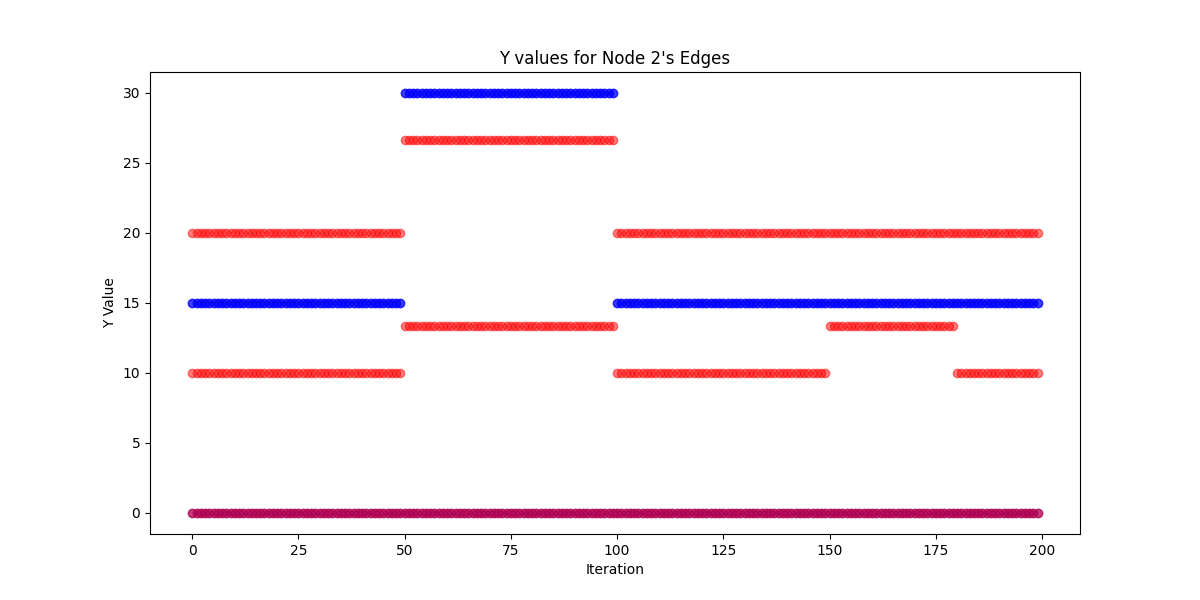

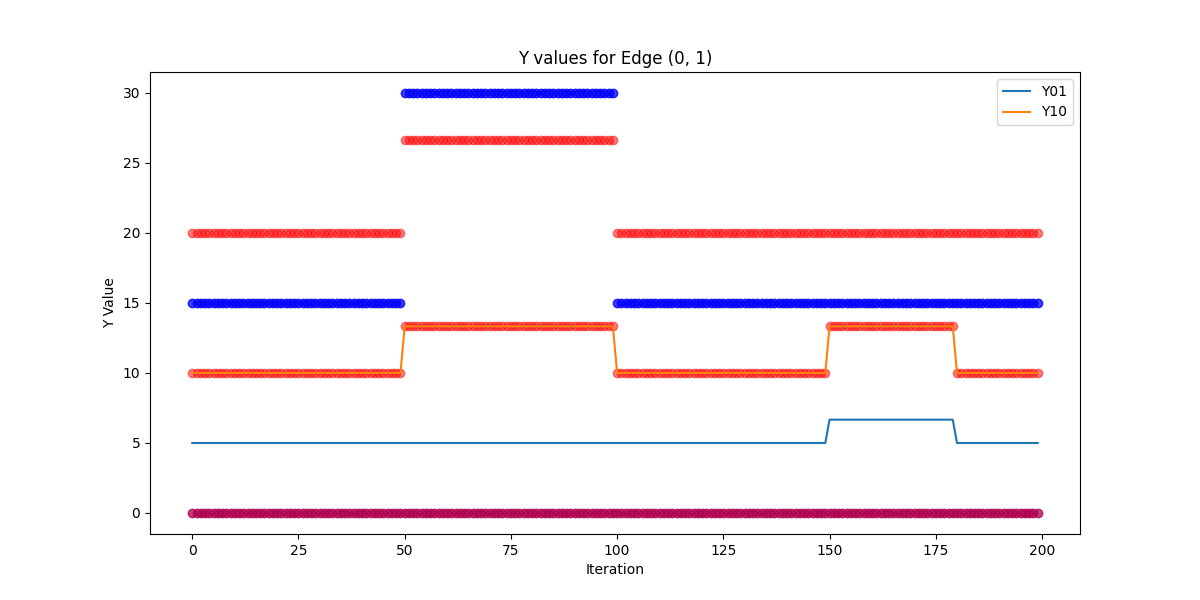

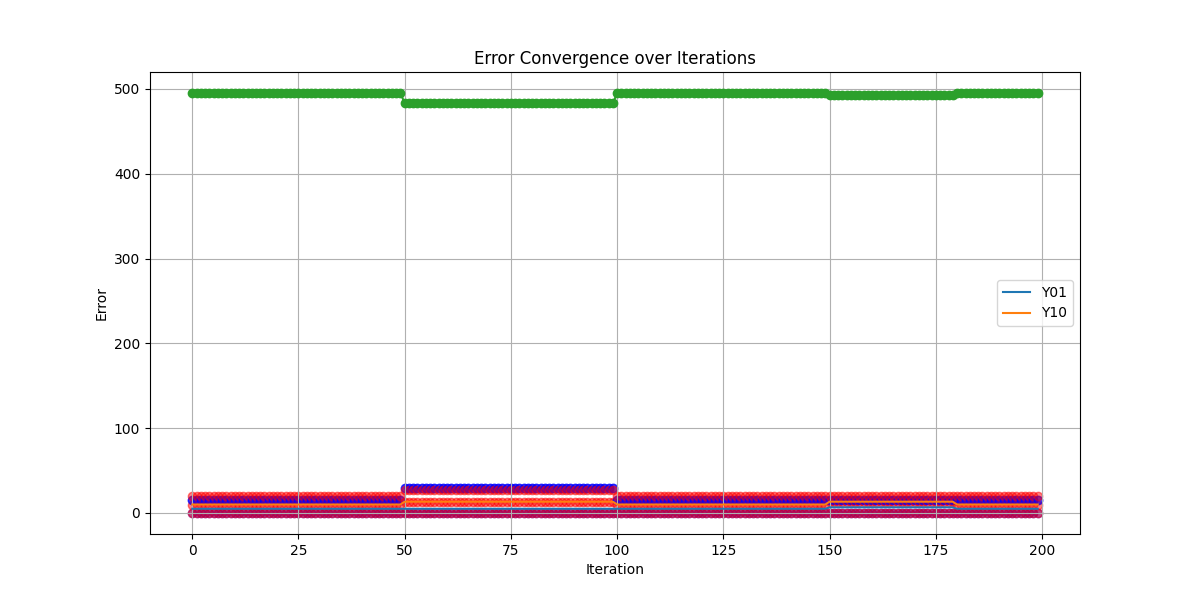

In [36]:
if __name__ == '__main__':
    main()